<a href="https://colab.research.google.com/github/seunghyeon98/NLP/blob/main/transformer_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References
* https://devhwi.tistory.com/43
* https://cpm0722.github.io/pytorch-implementation/transformer

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import math


# Transformer

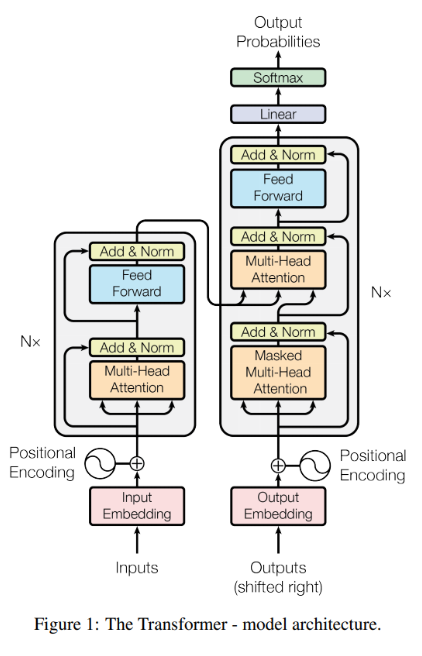

## 구현해야 할 것

* Multi-Head Attention
  * Self Attentioin
  * Encoder-Decoder Attention

* Masked Multi-Head Attention

* Add & Norm

* Feed Forward

* POS EMB

* Input EMB

* Output EMB

* Linear

* Soft Max

## Multi-Head Attention (Scaled Dot-Product Attention)

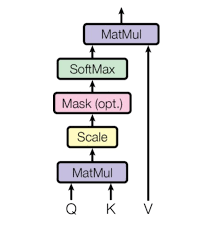

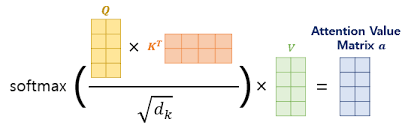

Attention(Q, K, V ) = softmax(QKT
√
dk
)V

In [1]:
def scaled_dot_product_attention(self, q, k, v, mask = None):

  d_k = k.size()[-1] # key의 길이

  transposed_k = torch.transpose(k,3,2) # 3차원과 2차원을 교환

  attention_score = torch.matmul(q,transposed_k)

  # key의 제곱근으로 나누는 이유는, scaling하기 위함.
  # scaling을 하는 이유는 값의 크기가 너무 커지지 않도록 위함이여, gradient vanishing이 발생할 수 있기때문이라고함.
  attention_score = output / math.sqrt(d_k)

  # pad maksing
    # 문장의 길이가 각각 다를 경우, 문장 마다 토큰의 갯수도 다를 것이다.
    # 이 때, seq_len을 정하여 seq_len보다 길이가 짧은 문장의 빈 token에 대해서는 attention이 부여되어서는 안된다.
    # 실제로 존재하지 않은 토큰에 대해서 계산이되면 안되기 때문.
    # 이를 통해 존재하지 않은 토큰에 대해선 pad masking을 사용하여 값이 0인 토큰을 반영한다.
    # 이 때, pad masking은 pad token의 값이 soft max에 반영되지 않게 하기위해 soft max이전에 수행되어야한다.
  if mask is not None:
    attention_score = attention_score.masked_fill(mask.unsqueeze(1).unsqueeze(-1),0)

  # attention score는 soft max를 통해 확률값으로 변환됨.
  # 그 결과 모든 attention score를 더하면 1이된다.
  # soft max를 통해 나온 확률들은 attention probability라고 부른다.
  attention_probability = F.softmax(attention_score, -1)

  # 이 attention_probability를 최종적으로 V와 내적하여, value에 대해서 어텐션 값을 반영하게된다.
  output = torch.matmul(attention_probability, v)

  return output


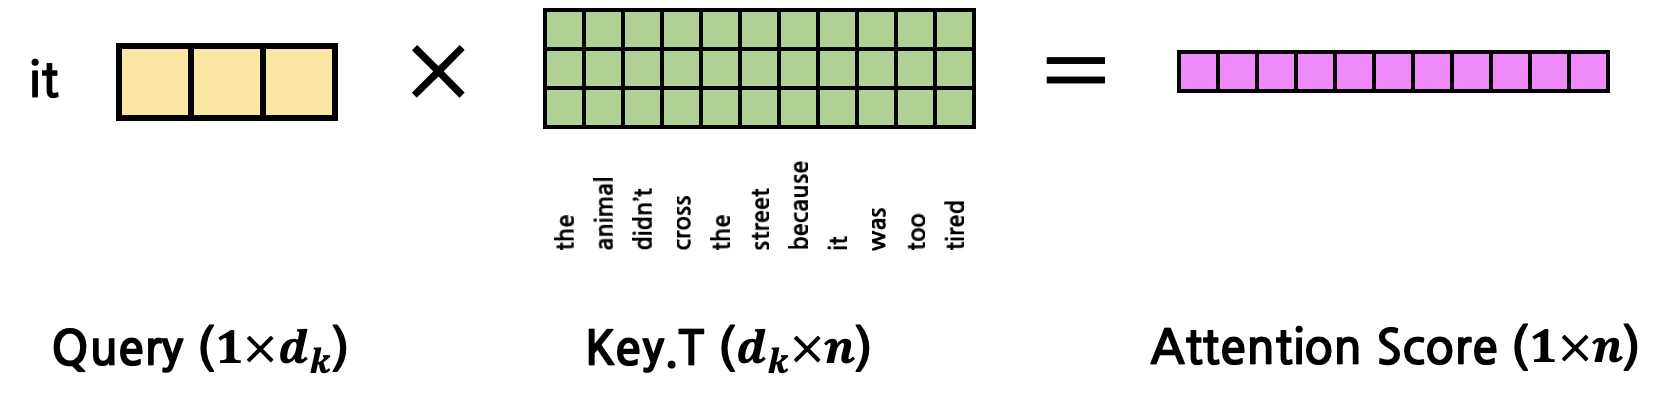

query와 key에 대한 attention계산에 의해
query 에 해당하는 it 토큰에 대한 attention score값이 도출된다.

## Multi-Head Attention

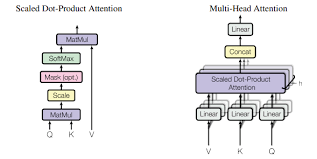

multi head attention은 scaled dot product attention을 query에 해당하는 value값들을 참조하기 위해 사용한다.
query, key, value를 그대로 사용하는 것이 아니라, 여러개의 head로 나누고 query, key, value를 linear projection 한 후, 사용한다.

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, dim_num=512, head_num=8):
    super().__init__()

    self.head_num = head_num
    self.dim_num = dim_num

    self.query_embed = nn.Linear(dim_num,dim_num)
    self.key_embed = nn.Linear(dim_num,dim_num)
    self.value_embed = nn.Linear(dim_num,dim_num)
    self.output_embed = nn.Linear(dim_num,dim_num)


  def scaled_dot_product_attention(self, q, k, v, mask = None):

    d_k = k.size()[-1] # key의 길이

    transposed_k = torch.transpose(k,3,2) # 3차원과 2차원을 교환

    output = torch.matmul(q,transposed_k)
    scaled_output = output / math.sqrt(d_k)

    # ?
    if mask is not None:
      scaled_output = scaled_output.masked_fill(mask.unsqueeze(1).unsqueeze(-1),0)

    SoftMaxed_output = F.softmax(output, -1)

    matmuled_v = torch.matmul(SoftMaxed_output, v)

    return matmuled_v

  def forward(self, q, k, v, mask = None):

    batch_size = q.size()[0] # 배치사이즈는 query의 길이로

    q = self.query_embed(q).view(batch_size,-1, self.head_num, self.dim_num // self.head_num).transpose(1,2)
    k = self.key_embed(k).view(batch_size,-1,self.head_num, self.dim_num // self.head_num).transpose(1,2)
    v = self.value_embed(v).view(batch_size,-1,self.head_num,self.dim_num // self.head_num).transpose(1,2)


    output = scaled_dot_product_attention(q, k, v, mask)
    batch_num, head_num, seq_num, hidden_num = output.size()
    output = torch.transpose(output, 1, 2).contiguous().view((batch_size,-1,hidden_num*self.head_num))

    return output





## Add & Norm (Residual Add & Layer Norm)

인코더에서 pos emb이 된 벡터와, multi head attention의 출력값을 이용해서
add & norm에 의해 계산된다.

벡터 2개를 normalize함.

In [ ]:
def layer_norm(self, input):

  mean = torch.mean(input, dim = -1, keepdim = True)
  std = torch.std(input, dim = -1, keepdim = True)
  output = (input-mean) / std

  return output



In [ ]:
class AddNorm(nn.Module):
  def __init__(self):
    super().__init__()

  def layer_norm(self, input):

    mean = torch.mean(input, dim = -1, keepdim = True)
    std = torch.std(input, dim = -1, keepdim = True)
    output = (input-mean) / std

    return output

  def forward(self, input, residual):
    return residual + self.layer_norm(input)

## Feed Forward

FFN(x) = max(0, xW1 + b1)W2 + b2

Feed Forward는 Fully Connected Layer -> Relu -> Fully Connected Layer로 구성되어 있음


In [ ]:
class FeedForward(nn.Module):
  def __init__(self, dim_num=512):
    super().__init__()

# 선형변환 모듈 정의 : 출력 차원을 4배로 늘림으로써 모델은 복잡한 비선형 매핑을 학습할 수 있는
# 더 많은 매개변수와 용량을 갖게됨.
    self.layer1 = nn.Linear(dim_num, dim_num*4)
    self.layer2 = nn.Linear(dim_num*4,dim_num)

  def forward(self, input):
    output = self.layer1(input) # fully connected layer ->
    output = self.layer2(F.relu(output)) # -> relu -> fully connected layer

## Encoder

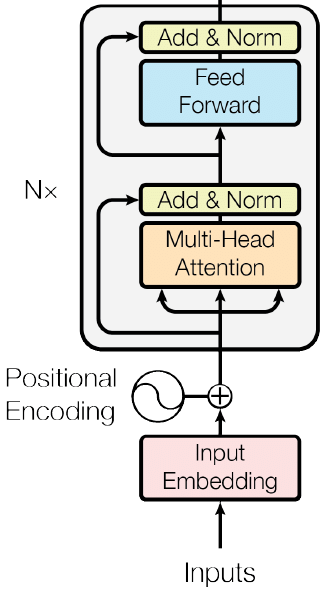

인코더는 multi head attn -> add & norm -> feed forawrd -> add & norm 으로 구성되어 있기 때문에, 앞서 구성한 모듈을 조립하면 된다

In [ ]:
class Encoder(nn.Module):
  def __init__(self,dim_num=512):
    super().__init__()

    self.multihead = MultiHeadAttention(dim_num = dim_num)
    self.residual_layer1 = AddNorm()
    self.feed_forward = FeedForward(dim_num = dim_num)
    self.residual_layer2 = AddNorm()

  def forward(self, q, k, v):
    multihead_output = self.multihead(q, k, v)
    residual1_output = self.residual_layer1(multihead_output,q)

    feed_forward_output = self.feed_forward(residual1_output)
    output = self.residual_layer2(feed_forward_output,residual1_output)

    return output

## Decoder

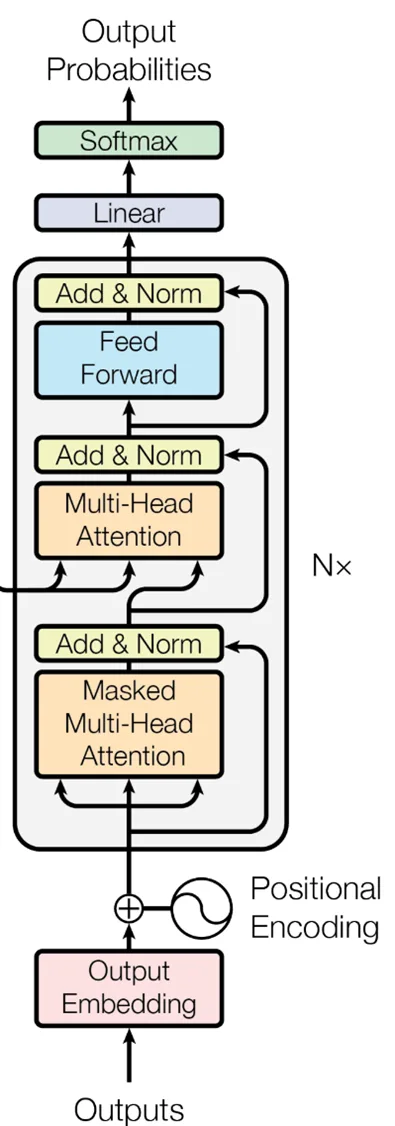

디코더는 masked multi-head attention -> add & norm -> multi-head attention -> add & norm -> feed forward -> add & norm 순으로 구성되어 있음

In [ ]:
class Decoder(nn.Module):
  def __init__(self, dim_num=512):
    super().__init__()

    self.masked_multihead = MultiHeadAttention(dim_num=dim_num)
    self.residual_layer1 = AddNorm()
    self.multihead = MultiHeadAttention(dim_num=dim_num)
    self.residual_layer2 = AddNorm()
    self.feed_forward = FeedForward(dim_num=dim_num)
    self.residual_layer3 = AddNorm()

  def forward(self, output_query, output_key, output_value, encoder_output, mask):

    masked_multihead_output = self.masked_multihead(output_query, output_key, output_value, mask)
    residual1_output = self.residual_layer1(masked_multihead_output, output_query)

    multihead_output = self.multihead(encoder_output, encoder_output, residual1_output, mask)
    residual2_output = self.residual_layer2(multihead_output, residual1_output)

    feedforwad_output = self.feed_forward(residual2_output)
    residual3_output = self.residual_layer3(feedforwad_output, residual2_output)

    return residual3_output


## Positional Encoding

시퀀스의 순서를 고려하기 위해 pos emb를 추가하여 시퀀스의 순서를 표현한다.
이 때, 짝수번째 token과 홀수번째 token이 각기 다른 식을 따른다.


In [ ]:
def position_encoding(self, position_max_length=100):
  # 0부터 설정한 position_max_length길이 만큼 크기가 1인 tensor을 만든다
  position = torch.arange(0,position_max_length, dtype = torch.float).unsqueeze(1)

  # 값이 0이고, pos_max_len, hidden_dim 크기인 pe 텐서 설정.
  pe = torch.zeros(position_max_length, self.hidden_dim)

  # div_term = 10000^(2i/d_model)
  div_term = torch.pow(torch.ones(self.hidden_dim//2).fill_(10000),
                       torch.arange(0,self.hidden_dim,2)/torch.tensor(self.hidden_dim,dtype=torch.float32))

  # 짝수일 때 -> sin
  # 홀수일 때 -> cos
  pe[:, 0::2] = torch.sin(position/div_term)
  pe[:,1::2] = torch.cos(position/div_term)

  # 2차원으로 수정
  pe = pe.unsqueeze(0)

  # pytorch에서 pe를 버퍼로 등록하는데 사용됨.
  # 학습에는 필요 없지만 사용은 해야하는 tensor를 사용할 때 register_buffer를 이용한다.
  self.register_buffer('pe',pe)

  return pe



## Input & Output Embedding

* embedding은 nn.Embedding을 통해 사용하며,
* Embedding의 첫 번째 인자는 input 데이터의 total_word 개수, 두 번째 인자는 hidden dimension의 수이다.
* total word num은 sequence dictionary에 존재하는 unique value의 개수를 의미한다.



In [ ]:
self.input_data_embed = nn.Embedding(total_word_num,self.hidden_dim)
self.output_data_embed = nn.Embedding(total_word_num,self.hidden_dim)

NameError: name 'total_word_num' is not defined

## Transformer

In [ ]:
class Transformer(nn.Module):
  def __init__(self,encoder_num =6, decoder_num =6, hidden_dim=512, max_encoder_seq_length=100,
               max_decoder_seq_length=100):
    super().__init__()

    self.encoder_num = encoder_num
    self.hidden_dim = hidden_dim
    self.max_encoder_seq_length = max_encoder_seq_length
    self.max_decoder_seq_length = max_decoder_seq_length

    self.input_data_embed = nn.Embedding(max_encoder_seq_length,hidden_dim)
    self.Encoders = [Encoder(dim_num = hidden_dim) for _ in range(encoder_num)]

    self.output_data_embed = nn.Embedding(max_decoder_seq_length,hidden_dim)
    self.Decoders = [Decoder(dim_num=hidden_dim) for _ in range(decoder_num)]

    self.last_linear_layer = nn.Linear(hidden_dim,max_decoder_seq_length)


  def position_encoding(self, position_max_length=100):
    # 0부터 설정한 position_max_length길이 만큼 크기가 1인 tensor을 만든다
    position = torch.arange(0,position_max_length, dtype = torch.float).unsqueeze(1)

    # 값이 0이고, pos_max_len, hidden_dim 크기인 pe 텐서 설정.
    pe = torch.zeros(position_max_length, self.hidden_dim)

    # div_term = 10000^(2i/d_model)
    div_term = torch.pow(torch.ones(self.hidden_dim//2).fill_(10000),
                        torch.arange(0,self.hidden_dim,2)/torch.tensor(self.hidden_dim,dtype=torch.float32))

    # 짝수일 때 -> sin
    # 홀수일 때 -> cos
    pe[:, 0::2] = torch.sin(position/div_term)
    pe[:,1::2] = torch.cos(position/div_term)

    # 2차원으로 수정
    pe = pe.unsqueeze(0)

    # pytorch에서 pe를 버퍼로 등록하는데 사용됨.
    # 학습에는 필요 없지만 사용은 해야하는 tensor를 사용할 때 register_buffer를 이용한다.
    self.register_buffer('pe',pe)

    return pe

  def forward(self, input, output, mask):

    # encoder

    input_embed = self.input_data_embed(input)
    input_embed += self.position_encoding(self.max_encoder_seq_length)
    q, k, v = input_embed, input_embed, input_embed

    for encoder in self.Encoders:
      encoder_output = encoder(q,k,v)
      q = encoder_output
      k = encoder_output
      v = encoder_output


    # decoder

    output_embed = self.output_data_embed(output)
    output += self.position_encoding(self.max_decoder_seq_length)
    output_embed = output_embed.masked_fill(mask.unsqueeze(-1),0)
    decoder_query, decoder_key, decoder_value = output_embed, output_embed, output_embed

    for decoder in self.Decoders:
      decoder_output = decoder(decoder_query, decoder_key, decoder_value, encoder_output,mask)
      decoder_query, decoder_key, decoder_value = decoder_output

    output = F.softmax(self.last_linear_layer(decoder_output),dim=-1)


    return output








In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

max_seq_length = 100
total_word_num = 100


class MultiHeadAttention(nn.Module):
    def __init__(self, dim_num=512, head_num=8):
        super().__init__()
        self.head_num = head_num
        self.dim_num = dim_num

        self.query_embed = nn.Linear(dim_num, dim_num)
        self.key_embed = nn.Linear(dim_num, dim_num)
        self.value_embed = nn.Linear(dim_num, dim_num)
        self.output_embed = nn.Linear(dim_num, dim_num)

    # q, k Shape (Batch X Head_num X token_length X hidden)
    # q는 현재 token을 embedding
    # k는 문장 전체의 token을 embedding
    # output = 문장 내에 어느 token에 주의를 기울일지 선택
    def scaled_dot_product_attention(self, q, k, v, mask=None):
        d_k = k.size()[-1]
        k_transpose = torch.transpose(k, 3, 2)

        output = torch.matmul(q, k_transpose)
        output = output / math.sqrt(d_k)
        if mask is not None:
            output = output.masked_fill(mask.bool().unsqueeze(1).unsqueeze(-1), 0)

        output = F.softmax(output, -1)
        output = torch.matmul(output, v)

        return output

    def forward(self, q, k, v, mask=None):
        batch_size = q.size()[0]

        # 순서 유지 때문에 view 후 transpose 사용
        q = self.query_embed(q).view(batch_size, -1, self.head_num, self.dim_num // self.head_num).transpose(1, 2)
        k = self.key_embed(k).view(batch_size, -1, self.head_num, self.dim_num // self.head_num).transpose(1, 2)
        v = self.value_embed(v).view(batch_size, -1, self.head_num, self.dim_num // self.head_num).transpose(1, 2)

        output = self.scaled_dot_product_attention(q, k, v, mask)
        batch_num, head_num, seq_num, hidden_num = output.size()
        output = torch.transpose(output, 1, 2).contiguous().view((batch_size, -1, hidden_num * self.head_num))

        return output


class FeedForward(nn.Module):
    def __init__(self, dim_num=512):
        super().__init__()
        self.layer1 = nn.Linear(dim_num, dim_num * 4)
        self.layer2 = nn.Linear(dim_num * 4, dim_num)

    def forward(self, input):
        output = self.layer1(input)
        output = self.layer2(F.relu(output))

        return output


# Layer norm
class AddLayerNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def layer_norm(self, input):
        mean = torch.mean(input, dim=-1, keepdim=True)
        std = torch.std(input, dim=-1, keepdim=True)
        output = (input - mean) / std
        return output

    def forward(self, input, residual):
        return residual + self.layer_norm(input)


class Encoder(nn.Module):
    def __init__(self, dim_num=512):
        super().__init__()
        self.multihead = MultiHeadAttention(dim_num=dim_num)
        self.residual_layer1 = AddLayerNorm()
        self.feed_forward = FeedForward(dim_num=dim_num)
        self.residual_layer2 = AddLayerNorm()

    def forward(self, q, k, v):
        multihead_output = self.multihead(q, k, v)
        residual1_output = self.residual_layer1(multihead_output, q)
        feedforward_output = self.feed_forward(residual1_output)
        output = self.residual_layer2(feedforward_output, residual1_output)

        return output


class Decoder(nn.Module):
    def __init__(self, dim_num=512):
        super().__init__()

        self.masked_multihead = MultiHeadAttention(dim_num=dim_num)
        self.residual_layer1 = AddLayerNorm()
        self.multihead = MultiHeadAttention(dim_num=dim_num)
        self.residual_layer2 = AddLayerNorm()
        self.feed_forward = FeedForward(dim_num=dim_num)
        self.residual_layer3 = AddLayerNorm()

    def forward(self, o_q, o_k, o_v, encoder_output, mask):
        masked_multihead_output = self.masked_multihead(o_q, o_k, o_v, mask)
        residual1_output = self.residual_layer1(masked_multihead_output, o_q)
        multihead_output = self.multihead(encoder_output, encoder_output, residual1_output, mask)
        residual2_output = self.residual_layer2(multihead_output, residual1_output)
        feedforward_output = self.feed_forward(residual2_output)
        output = self.residual_layer3(feedforward_output, residual2_output)

        return output


class Transformer(nn.Module):
    def __init__(self, encoder_num=6, decoder_num=6, hidden_dim=512, max_encoder_seq_length=100,
                 max_decoder_seq_length=100):
        super().__init__()

        self.encoder_num = encoder_num
        self.hidden_dim = hidden_dim
        self.max_encoder_seq_length = max_encoder_seq_length
        self.max_decoder_seq_length = max_decoder_seq_length

        self.input_data_embed = nn.Embedding(total_word_num, self.hidden_dim)
        self.Encoders = [Encoder(dim_num=hidden_dim) for _ in range(encoder_num)]

        self.output_data_embed = nn.Embedding(total_word_num, self.hidden_dim)
        self.Decoders = [Decoder(dim_num=hidden_dim) for _ in range(decoder_num)]

        self.last_linear_layer = nn.Linear(self.hidden_dim, max_seq_length)

    def position_encoding(self, position_max_length=100):
        position = torch.arange(0, position_max_length, dtype=torch.float).unsqueeze(1)
        pe = torch.zeros(position_max_length, self.hidden_dim)
        div_term = torch.pow(torch.ones(self.hidden_dim // 2).fill_(10000),
                             torch.arange(0, self.hidden_dim, 2) / torch.tensor(self.hidden_dim, dtype=torch.float32))
        pe[:, 0::2] = torch.sin(position / div_term)
        pe[:, 1::2] = torch.cos(position / div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

        return pe

    def forward(self, input, output, mask):

        input_embed = self.input_data_embed(input)
        input_embed += self.position_encoding(self.max_encoder_seq_length)
        q, k, v = input_embed, input_embed, input_embed

        for encoder in self.Encoders:
            encoder_output = encoder(q, k, v)
            q = encoder_output
            k = encoder_output
            v = encoder_output

        output_embed = self.output_data_embed(output)
        output_embed += self.position_encoding(self.max_decoder_seq_length)
        output_embed = output_embed.masked_fill(mask.bool().unsqueeze(-1), 0)
        d_q, d_k, d_v = output_embed, output_embed, output_embed

        for decoder in self.Decoders:
            decoder_output = decoder(d_q, d_k, d_v, encoder_output, mask)
            d_q = decoder_output
            d_k = decoder_output
            d_v = decoder_output

        output = F.softmax(self.last_linear_layer(decoder_output), dim=-1)
        return output


if __name__ == '__main__':
    model = Transformer()

    input = torch.randint(low=0, high=max_seq_length, size=(64, max_seq_length), dtype=torch.long)
    output = torch.randint(low=0, high=max_seq_length, size=(64, max_seq_length), dtype=torch.long)
    print(f'input: {input}, output: {output}')

    # 임의로 mask token부여
    mask = torch.zeros((64, max_seq_length))
    mask[:, :30] = 1
    print(f'mask: {mask}')


    output = model(input, output, mask)
    _, pred = torch.max(output, dim=-1)


    print(f'output: {output},pred: {pred}')
    print(pred.shape)

input: tensor([[83, 17, 70,  ..., 80, 70, 20],
        [54, 41, 90,  ..., 15, 86, 68],
        [11, 66, 32,  ..., 89, 21, 53],
        ...,
        [38, 10, 40,  ..., 35, 35, 23],
        [68, 60, 39,  ..., 16, 35, 32],
        [53, 45, 63,  ..., 85, 68, 19]]), output: tensor([[31, 93, 72,  ..., 81, 85, 22],
        [44, 71, 26,  ...,  9, 85, 29],
        [39, 92, 90,  ..., 57, 42, 32],
        ...,
        [70, 26, 92,  ..., 49, 15, 38],
        [54, 58, 79,  ..., 25, 74, 27],
        [90, 50, 56,  ..., 25, 68, 85]])
mask: tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])
output: tensor([[[5.7519e-07, 2.1431e-03, 2.6811e-04,  ..., 2.4642e-07,
          2.8567e-02, 3.0292e-05],
         [5.7519e-07, 2.1431e-03, 2.6811e-04,  ..., 2.4642e-07,
          2.8567e-02, 3.0292e-05],
         [